# MINI PROJECT - Cart Abandonment Analysis and Prediction using Association Rule Mining and Classification

## Importing Modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from itertools import combinations
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectFromModel

## Load Datasets and Merging the Tables

In [2]:
customers = pd.read_csv('customer_table.csv')
devices = pd.read_csv('device_table.csv')
dates = pd.read_csv('date_table.csv', parse_dates=['date'])
products = pd.read_csv('product_table.csv')
sessions = pd.read_csv('fact_table.csv')

sessions = sessions.merge(customers, on='customer_id', how='left')
sessions = sessions.merge(devices, on='device_id', how='left')
sessions = sessions.merge(products, on='product_id', how='left')
sessions = sessions.merge(dates, on='date_id', how='left')

## Target Variable and Feature Engineering

In [3]:
sessions['abandoned'] = sessions['abandonment_time'].notna().astype(int)

sessions['day_of_week'] = sessions['date'].dt.day_name()
sessions['month'] = sessions['date'].dt.month_name()
sessions['is_weekend'] = sessions['day_of_week'].isin(['Saturday','Sunday']).astype(int)
sessions['price_quartile'] = pd.qcut(sessions['price'], 4, labels=['Low','Medium','High','Very High'])
sessions['cart_total'] = sessions['price'] * sessions['quantity']


### Cross-Feature Engineering

In [4]:
sessions['age_x_price'] = sessions['age'] * sessions['price']
sessions['high_price_flag'] = (sessions['price'] > sessions['price'].median()).astype(int)
sessions['weekend_high_price'] = sessions['is_weekend'] * sessions['high_price_flag']
sessions['rule_apparel'] = (sessions['category'] == 'Apparel').astype(int)
sessions['rule_android'] = (sessions['os'] == 'Android').astype(int)
sessions['rule_price_vhigh'] = (sessions['price'] > sessions['price'].quantile(0.75)).astype(int)
sessions['rule_weekend'] = sessions['is_weekend']
sessions['rule_tablet'] = (sessions['device_type'] == 'Tablet').astype(int)


## Association Rule Mining

In [5]:
transactions = []
for _, row in sessions.iterrows():
    items = [
        f"Device_{row.device_type}", 
        f"OS_{row.os}", 
        f"Category_{row.category}",
        f"Price_{row.price_quartile}", 
        "Weekend" if row.is_weekend else "Weekday"
    ]
    
    label = "Abandoned" if row.abandoned == 1 else "Purchased"
    transactions.append((set(items), label))

from collections import Counter, defaultdict

item_counter = Counter()
for items, _ in transactions:
    item_counter.update(items)

min_support = 0.05
min_count = int(min_support * len(transactions))

frequent_items = {item for item, count in item_counter.items() if count >= min_count}

rules = []
label_counts = Counter(label for _, label in transactions)

for item in frequent_items:
    for label in ["Abandoned", "Purchased"]:
        joint_count = sum(1 for items, lbl in transactions if item in items and lbl == label)
        if joint_count >= min_count:
            support = joint_count / len(transactions)
            confidence = joint_count / (item_counter[item])
            rules.append((f"{item} ⇒ {label}", support, confidence))

# Convert to DataFrame
rules_df = pd.DataFrame(rules, columns=["rule", "support", "confidence"])
rules_df.sort_values("confidence", ascending=False, inplace=True)

print("\nTop Association Rules:")
print(rules_df.head(10))



Top Association Rules:
                                           rule  support  confidence
2                  Category_Apparel ⇒ Abandoned   0.1052    0.524950
0              Category_Electronics ⇒ Abandoned   0.1102    0.518344
28                       OS_Android ⇒ Abandoned   0.0988    0.516736
20                  Price_Very High ⇒ Abandoned   0.1204    0.513652
6                           Weekend ⇒ Abandoned   0.1482    0.512803
15          Category_Home & Kitchen ⇒ Purchased   0.1042    0.511286
4                     Device_Mobile ⇒ Abandoned   0.1992    0.508163
27  Category_Beauty & Personal Care ⇒ Purchased   0.0926    0.506011
12                     Price_Medium ⇒ Abandoned   0.1256    0.505636
24                    Device_Tablet ⇒ Abandoned   0.2036    0.504210


## Classification

In [6]:
# Combine features + rules
rule_cols = ['rule_apparel', 'rule_android', 'rule_price_vhigh', 'rule_weekend', 'rule_tablet']
base_cols = ['device_type','os','category','quantity','price','age',
             'gender','city','day_of_week','month','is_weekend','cart_total']
features = pd.get_dummies(sessions[base_cols + rule_cols], drop_first=True)
target = sessions['abandoned']

# Feature selection using Random Forest
sfm = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42), threshold="median")
sfm.fit(features, target)
features_selected = sfm.transform(features)

# Split data
X_train, X_test, y_train, y_test = train_test_split(features_selected, target, 
                                                    test_size=0.3, random_state=42, stratify=target)

# Define and train models
models = {
    "LogisticRegression": LogisticRegression(max_iter=500, solver='liblinear'),
    "DecisionTree": DecisionTreeClassifier(),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(
        n_estimators=300,
        max_depth=8,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='logloss',
        use_label_encoder=False
    )
}

# Evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    probs = model.predict_proba(X_test)[:,1]
    acc = accuracy_score(y_test, preds)
    auc = roc_auc_score(y_test, probs)
    results[name] = (acc, auc)
    print(f"{name}: Accuracy={acc:.3f}, ROC AUC={auc:.3f}")

# XGBoost threshold tuning
xgb_model = models['XGBoost']
xgb_probs = xgb_model.predict_proba(X_test)[:, 1]
custom_thresh = 0.4
xgb_custom_pred = (xgb_probs > custom_thresh).astype(int)

print("\nXGBoost with threshold 0.4:")
print(classification_report(y_test, xgb_custom_pred))

LogisticRegression: Accuracy=0.495, ROC AUC=0.492
DecisionTree: Accuracy=0.488, ROC AUC=0.489
RandomForest: Accuracy=0.505, ROC AUC=0.511


C:\Users\Ahmad Zakariya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [14:06:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost: Accuracy=0.493, ROC AUC=0.486

XGBoost with threshold 0.4:
              precision    recall  f1-score   support

           0       0.50      0.35      0.41       743
           1       0.51      0.66      0.57       757

    accuracy                           0.50      1500
   macro avg       0.50      0.50      0.49      1500
weighted avg       0.50      0.50      0.49      1500



In [7]:
from sklearn.ensemble import StackingClassifier

stack = StackingClassifier(
    estimators=[
        ('lr', LogisticRegression(max_iter=500, solver='liblinear')),
        ('dt', DecisionTreeClassifier(max_depth=5)),
        ('xgb', XGBClassifier(n_estimators=200, learning_rate=0.05, use_label_encoder=False, eval_metric='logloss'))
    ],
    final_estimator=RandomForestClassifier(n_estimators=100)
)

stack.fit(X_train, y_train)
stack_preds = stack.predict(X_test)
stack_probs = stack.predict_proba(X_test)[:,1]

print("Stacking Accuracy:", accuracy_score(y_test, stack_preds))
print("Stacking ROC AUC:", roc_auc_score(y_test, stack_probs))


C:\Users\Ahmad Zakariya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [14:06:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Ahmad Zakariya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [14:06:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Ahmad Zakariya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [14:06:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameter

Stacking Accuracy: 0.49466666666666664
Stacking ROC AUC: 0.5053231303704678


## Random Forest


Top Features:
age                      0.227554
cart_total               0.187549
price                    0.159627
quantity                 0.068804
gender_Male              0.036759
os_Windows               0.032628
day_of_week_Tuesday      0.024345
day_of_week_Wednesday    0.024237
city_Sydney              0.023529
day_of_week_Monday       0.022860
dtype: float64


C:\Users\Ahmad Zakariya\AppData\Local\Temp\ipykernel_14200\1988263368.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette='viridis')


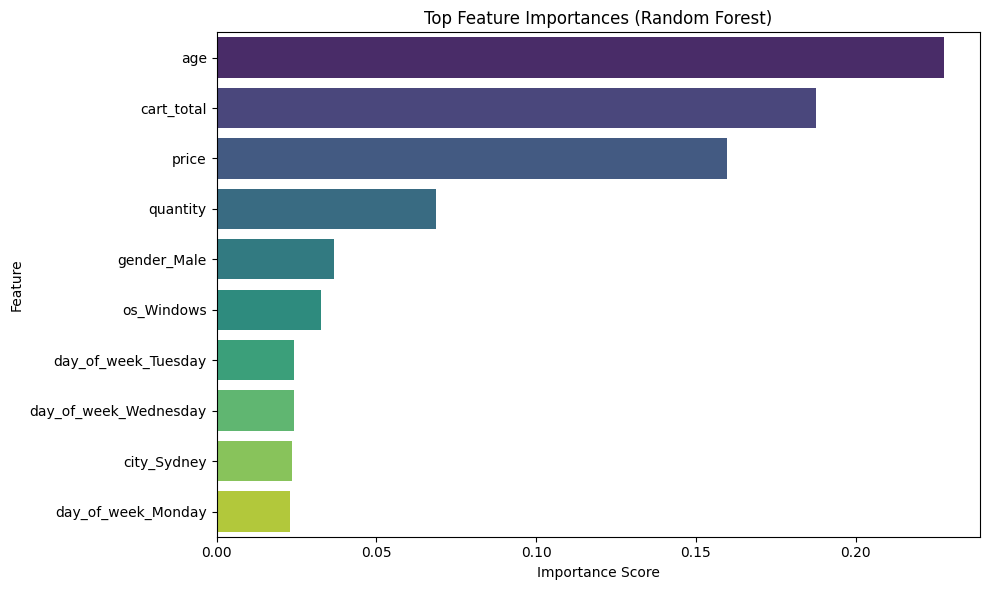

In [9]:
# Extract selected feature names after SelectFromModel
selected_mask = sfm.get_support()  # Boolean mask of selected features
selected_features = features.columns[selected_mask]  # Get actual names

# Random Forest feature importances using selected features
rf = models['RandomForest']
importances = pd.Series(rf.feature_importances_, index=selected_features)

# Get top 10 features
top_features = importances.sort_values(ascending=False).head(10)

print("\nTop Features:")
print(top_features)

# Feature Importance Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index, palette='viridis')
plt.title('Top Feature Importances (Random Forest)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


## Association Rule Graph

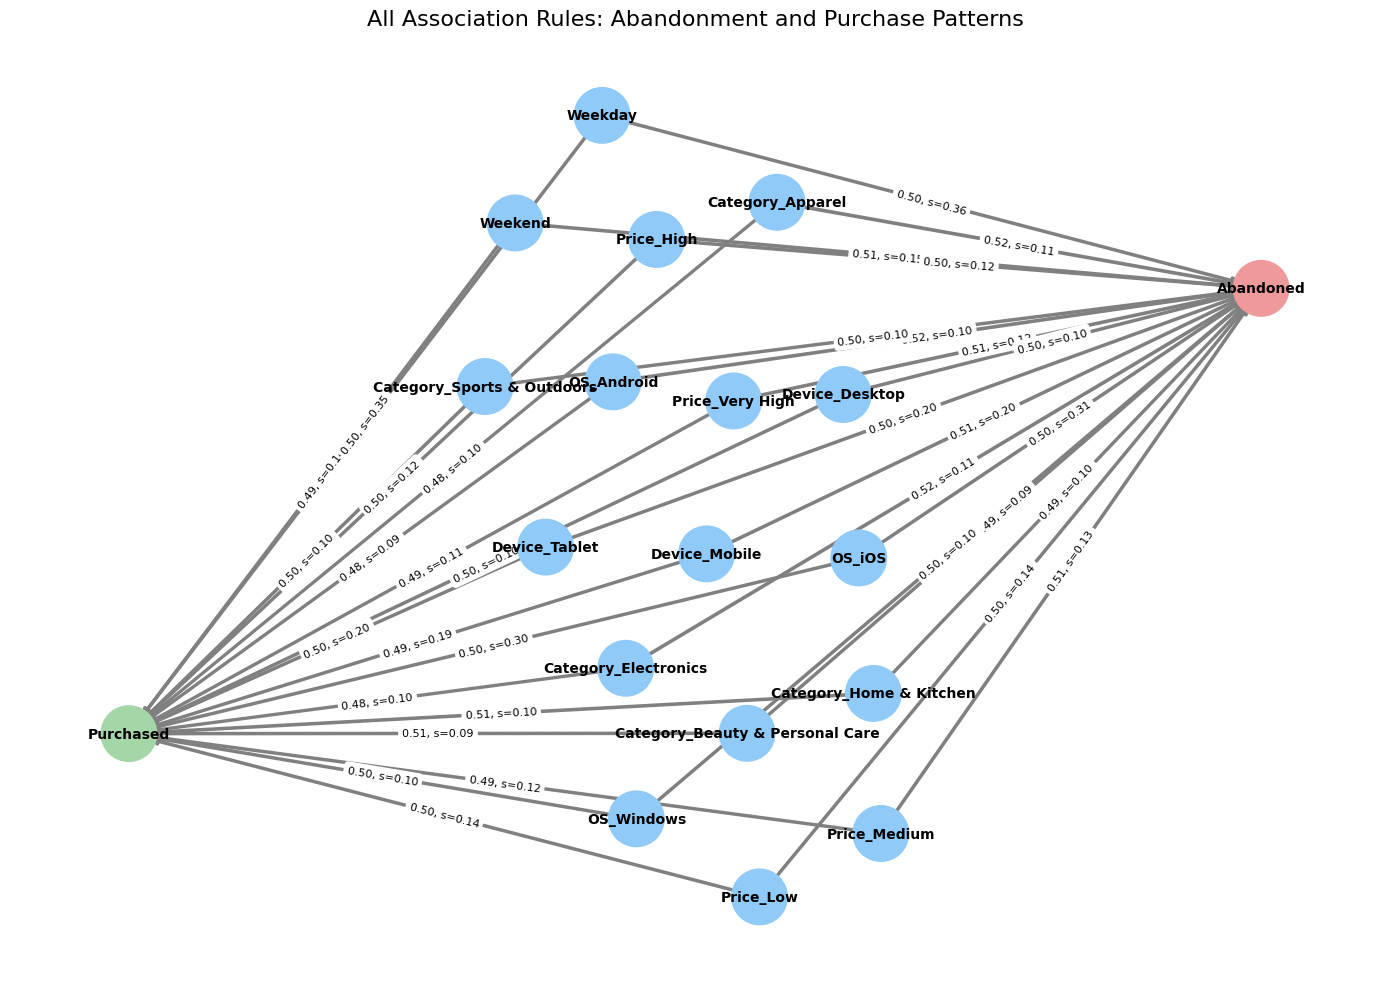

In [11]:
import matplotlib.pyplot as plt
import networkx as nx

# Convert rules_df into (antecedent, consequent, confidence, support)
rules_data = []
for _, row in rules_df.iterrows():
    try:
        antecedent, consequent = row['rule'].split(" ⇒ ")
        confidence = row['confidence']
        support = row['support']
        rules_data.append((antecedent, consequent, confidence, support))
    except:
        continue

# Build the graph
G = nx.DiGraph()
for antecedent, consequent, confidence, support in rules_data:
    label = f"{confidence:.2f}, s={support:.2f}"
    G.add_edge(antecedent, consequent, weight=confidence, label=label)

# Plot
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, seed=42, k=0.8)  # Adjust k to spread out nodes
edges = G.edges(data=True)
weights = [d['weight'] * 5 for _, _, d in edges]  # scale confidence for thickness

# Color coding
node_colors = []
for node in G.nodes():
    if node == 'Abandoned':
        node_colors.append('#EF9A9A')  # Red-ish for abandoned
    elif node == 'Purchased':
        node_colors.append('#A5D6A7')  # Green for purchase
    else:
        node_colors.append('#90CAF9')  # Blue for feature nodes

# Draw
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=1600)
nx.draw_networkx_edges(G, pos, edge_color='gray', width=weights, arrows=True, arrowstyle='-|>', min_target_margin=15)
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

# Edge labels with confidence and support
edge_labels = {(u, v): d['label'] for u, v, d in edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

plt.title("All Association Rules: Abandonment and Purchase Patterns", fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()
